### This is implementation of algorithm for Mechanical Turk task. Voted Accuracy approach as suggested by Prof. Jessica Hodgins.

In [1]:
from __future__ import division
import boto3
import datetime
import json
import pandas as pd
import os
from pathlib import Path
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  

In [2]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import accuracy_score
import numpy as np
from numpy import interp
from pycm import *
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
from itertools import combinations
import random
from collections import Counter

In [4]:
def time_converter(o):
    if isinstance(o, datetime.datetime):
        return o.__str__()

rootpath = os.path.join(r'C:\Users\nerdybug\Documents\mturk-task-helper')
answers_path = os.path.join(rootpath,"batch100_HITs","answers", "1selwyn_answers_classification_task_layout2_3_batch100.csv")
results_path = os.path.join(rootpath,"batch100_HITs","all","voting")
output_results = os.path.join(rootpath,"batch100_HITs","all","voting","results")

if not os.path.exists(output_results):
    os.mkdir(output_results)

In [ ]:
assert os.path.exists(rootpath) and os.path.exists(answers_path) and os.path.exists(results_path) and os.path.exists(output_results),
        "One of the aforementioned paths do not exist or incorrect. Please check before proceeding to next cell"

In [5]:

region_name = 'us-east-1'

endpoint_url = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
prod_url = "https://mturk-requester.us-east-1.amazonaws.com"

client = boto3.client(
    'mturk',
    endpoint_url=prod_url,
    region_name=region_name,
)
# This will return $10,000.00 in the MTurk Developer Sandbox
print(client.get_account_balance()['AvailableBalance'])

178.50


In [6]:
files = os.listdir(os.path.join(results_path))
files

['all_results.csv', 'results']

In [7]:
def save_file(final_results:[dict],filename_with_ext):
    result = pd.DataFrame.from_dict(final_results)
    result.to_csv(os.path.join(os.getcwd(),filename_with_ext), index=False)

In [8]:
filename = 'all_results.csv'
df = pd.read_csv(os.path.join(results_path, filename))

In [9]:
df.columns

Index(['image_url', 'submitted', 'answer', 'score', 'WorkerId', 'HITId'], dtype='object')

### All answers are labels submitted by workers merged with actual answers for comparison.

In [10]:
all_answers = df[['HITId','WorkerId','image_url','submitted', 'answer', 'score']]

In [11]:
all_answers.columns

Index(['HITId', 'WorkerId', 'image_url', 'submitted', 'answer', 'score'], dtype='object')

### List out all unique workers in this set (which is all 3 batches from each of 3 layouts)

In [12]:
workers = list(all_answers.groupby(['WorkerId']).groups.keys())
print("Number of unique workers",len(workers))

Number of unique workers 11


In [13]:
workerid = workers[0]

In [14]:
all_answers.loc[all_answers['WorkerId'] == workerid]['image_url']

262    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
263    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
264    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
265    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
266    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
267    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
268    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
269    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
270    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
271    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
272    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
273    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
274    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
275    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
276    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
277    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
278    https://mturk-s3-cg.s3.amazonaws.com/task1/bat...
279    https://mturk-s3-cg.s3.a

### Ground truth i.e the answers of each of vehicle images for all sub-images generated earlier.
#### Note we will not be using this however for now, since we are conducting experiment on a small batch.
#### for 25 images, for this one time, we have merged answers with submitted answers for easier comparison.
#### This is just for reference in case of future tasks.

In [15]:
answers = pd.read_csv(answers_path)

In [16]:
answers.columns

Index(['image_name', 'W', 'H', 'x', 'y', 'class', 'image_url'], dtype='object')

In [17]:
pd.set_option('display.max_colwidth', None)
all_answers['answer'][:25],all_answers['image_url'][:25]

(0           Small vehicles
 1     Specialized vehicles
 2           Small trailers
 3           Small vehicles
 4           Small vehicles
 5           Small vehicles
 6           Small vehicles
 7             Vans and RVs
 8     Specialized vehicles
 9     Specialized vehicles
 10    Specialized vehicles
 11          Small trailers
 12          Small trailers
 13          Small vehicles
 14            Vans and RVs
 15                  Trucks
 16    Specialized vehicles
 17          Small trailers
 18    Specialized vehicles
 19          Small trailers
 20            Vans and RVs
 21          Small vehicles
 22          Small vehicles
 23                  Trucks
 24          Small trailers
 Name: answer, dtype: object,
 0      https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0001/0001_0001_2462-6635.png
 1     https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0001/0001_0001_7835-19327.png
 2     https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0002/0001_0002_131

In [18]:
this_answers = all_answers['answer'][:25].to_list()
print("Number of answers",len(this_answers))

Number of answers 25


In [19]:
labels = set(answers)
labels = ['Trucks', 'Small trailers', 'Specialized vehicles',
       'Large trailers', 'Small vehicles', 'Vans and RVs','Buses']

In [20]:
hitids = list(all_answers.groupby(['HITId']).groups.keys())

In [21]:
print("Number of HITs",len(hitids))

Number of HITs 3


In [22]:
hit_wise_scores = dict()
for id in hitids:
    hit_wise_scores[id] = dict() 

In [23]:
import numpy as np
a = np.arange(1,16)

In [24]:
def cm2df(cm, labels, worker_hitid):
    df = pd.DataFrame()
    
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    
    #df.style.set_table_attributes("style='display:inline'").set_caption(worker_hitid)
    return df[labels]

In [25]:
def get_cm_stats(answer_labels, worker_hit_labels,labels,isnormalized=False,hitid="",g=""):
    old_settings = np.seterr(all='ignore')
    
    mcm = multilabel_confusion_matrix(answer_labels, worker_hit_labels, labels=labels)
    
    #extract individual components of confusion matrix for each class
    
    all_cm = []
    all_stats =[]
    series = pd.DataFrame()
    if not isnormalized:
        for cm,label in zip(mcm,labels):
            tn, fp, fn, tp = cm.ravel()
            tn = cm[0][0]
            fn = cm[1][0]
            tp = cm[1][1]
            fp = cm[0][1]

            # we want to send two different values sets, one with "tpr","precision","tnr","npv","fpr","fnr","fdr","accuracy" and
            # another with tp,fp,fn,tn (raw components from each class's confusion matrix)
            all_stats.append([hitid,g,label,tp/(tp+fn),tn/(tn+fp),tp/(tp+fp),tn/(tn+fn),fp/(fp+tn),fn/(tp+fn),fp/(tp+fp),(tp+tn)/(tp+fp+fn+tn)])
                                    #columns=["label","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"])
            all_cm.append([hitid,g,label,tp,fp,fn,tn])

    else:
        for cm,label in zip(mcm,labels):
            ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            #print(cm,cm.sum(axis=1),cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
            tn = ncm[0][0]
            fn = ncm[1][0]
            tp = ncm[1][1]
            fp = ncm[0][1]
            all_stats.append([hitid,g,label,tp/(tp+fn),tn/(tn+fp),tp/(tp+fp),tn/(tn+fn),fp/(fp+tn),fn/(tp+fn),fp/(tp+fp),(tp+tn)/(tp+fp+fn+tn)])
            all_cm.append([hitid,g,label,tp,fp,fn,tn])
    return all_cm, all_stats

###  The following is calculation for voting accuracy if 5 choose 3 workers were voted for minimum agreement

In [26]:
results = {} 
count = 1
groupwise_stats = pd.DataFrame(columns=["group","class","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"])
groupwise_cm = pd.DataFrame(columns=["hitid","group","class","tp","fp","fn","tn"])

all_cm = []
all_stats = []

In [27]:
# 5 choose 3
print("****************************5 choose 3*********************************************")
for hitid in hitids:
    results[hitid] = {}
    this_hit = all_answers[all_answers['HITId'] == hitid]
    workers = list(this_hit.groupby(['WorkerId']).groups.keys())
    c = list(combinations(workers,3 ))
    
    #print("combinations",len(c))
    count = 1
    
    # 5_c_3 computation over list of workers. We have 5 worker assignment per HIT task. So we choose 3 of 5 and calculate accuracy by vote.
    # 5 choose 3
    for v in c:
        g = str(count) + "_"+hitid
        #print(v)
        worker1 = this_hit[(this_hit['WorkerId'] == v[0])]['submitted'].to_list()
        worker2 = this_hit[(this_hit['WorkerId'] == v[1])]['submitted'].to_list()
        worker3 = this_hit[(this_hit['WorkerId'] == v[2])]['submitted'].to_list()
        three_answers = list(zip(worker1,worker2,worker3))
        this_group = []
        results[hitid][v] = []
        #print(len(three_answers))
        
        #for 3 workers
        
        for answer in three_answers:
            d = Counter(answer)
            val,l =  d.most_common(1)[0]
            
            #if atleast 3 or 2 answers among 3 workers' answers agree with each other
            # choose that answer
            if l == 3 or l==2:
                #print(val)
                this_group.append(val)
            
            # else pick one of the answers randomly
            else:
                this_group.append(random.choice(answer))

        cms, stats = get_cm_stats(this_answers, this_group, labels,True,hitid,str(count))
        for cm in cms:
            #print(cm)
            all_cm.append(cm)
            
        all_stats.extend(stats)
        results[hitid][v] = this_group
        count += 1
        
        #print(hitid, v, this_group)
    print(len(results[hitid]))
groupwise_stats = pd.DataFrame(all_stats, columns=["hitid","group","class","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"])
groupwise_cm = pd.DataFrame(all_cm, columns=["hitid","group","class","tp","fp","fn","tn"])
print("*****************",len(results),"*************************")

10
10
10
3


In [28]:
len(groupwise_cm)

210

In [29]:
groupwise_stats[["group","class","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"]].head()

,group,class,tpr,precision,tnr,npv,fpr,fnr,fdr,acc
0,1,Trucks,0.500000,1.000000,1.000000,0.666667,0.000000,0.500000,0.000000,0.750000
1,1,Small trailers,0.666667,0.947368,0.926829,0.739726,0.052632,0.333333,0.073171,0.807018
2,1,Specialized vehicles,0.833333,0.947368,0.940594,0.850394,0.052632,0.166667,0.059406,0.890351
3,1,Large trailers,NaN,0.960000,NaN,NaN,0.040000,NaN,NaN,NaN
4,1,Small vehicles,1.000000,0.882353,0.894737,1.000000,0.117647,0.000000,0.105263,0.941176


#### Group the results by worker's voted answers and plot the results for True Positive Rate

In [30]:
print("GroupBy /inner join over class vs True positive rate since we are interested to calculate onlt True Positive rate here (due to imbalanced class distriubutions)")
byclass = groupwise_stats[['class', 'tpr']].groupby(['class'],as_index = False)['tpr']
classes = byclass.mean()['class'].tolist()
mean = byclass.mean()
np.round(mean['tpr'],2).tolist()
#save_file(mean, os.path.join(output_results,"average_tpr_groupby_class_voted_accuracy.csv"))

[nan, nan, 0.73, 1.0, 0.81, 0.48, 0.5]

In [31]:
classes
ticks = [i for i in range(len(classes))]
ticks, classes

([0, 1, 2, 3, 4, 5, 6],
 ['Buses',
  'Large trailers',
  'Small trailers',
  'Small vehicles',
  'Specialized vehicles',
  'Trucks',
  'Vans and RVs'])

### get the variance and standard deviation for True Positive rate

In [32]:
var = byclass.var()['tpr']
std = byclass.std()['tpr']
var.tolist()

[nan,
 nan,
 0.010504469987228612,
 0.0,
 0.018646232439335896,
 0.12902298850574717,
 0.07471264367816094]

### save the results to CSV file

In [33]:
df1 = pd.DataFrame([mean['tpr'].tolist(), var.tolist(),std.tolist()],columns=[classes], index = ["Mean", "Variance", "Std Dev"] ).transpose()
df1.to_csv(os.path.join(output_results,"meanvarstd_tpr_groupby_class_voted_accuracy_5worker.csv"))

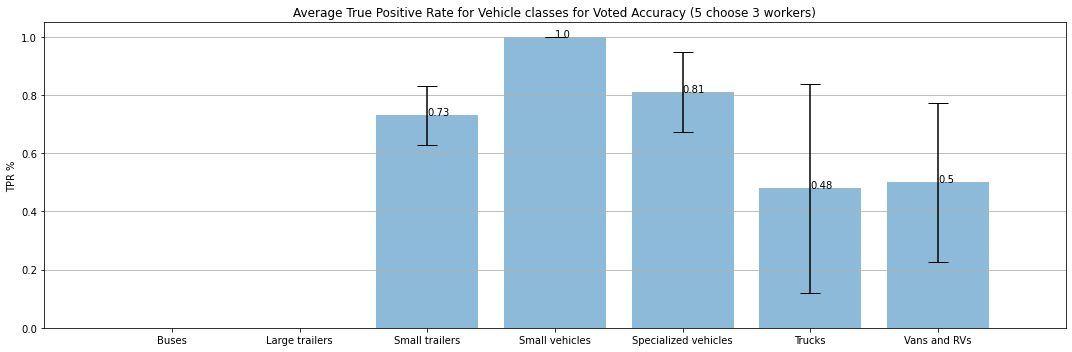

In [34]:
roundedmean = np.round(mean['tpr'],2)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(range(len(classes)), roundedmean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('TPR %')
ax.set_ylim(0,1.05)
ax.set_xlim(-1,len(classes))
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_title('Average True Positive Rate for Vehicle classes for Voted Accuracy (5 choose 3 workers)')
ax.yaxis.grid(True)
for i in range(len(classes)):
    ax.annotate(roundedmean[i], (i, roundedmean[i]))
# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(output_results,'bar_plot_with_error_bars_5workers.png'))
plt.show()

### Save the confusion matrix for 5 choose 3 voted accuracy to CSV file

In [35]:
save_file(groupwise_cm,os.path.join(output_results,"groupwise_cm.csv"))

###  The following is calculation for voting accuracy if all 5 workers were voted for minimum agreement

In [36]:
results = {} 
count = 1
groupwise_stats_5 = pd.DataFrame(columns=["group","class","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"])
groupwise_cm_5 = pd.DataFrame(columns=["hitid","group","class","tp","fp","fn","tn"])

all_cm = []
all_stats = []

#### In this variation of Voted accuracy algorithm, we attempt to find accuracy if 5 workers were chosen.

In [37]:
print("****************************5 workers voted accuracy (we want odd number so we can assess accuracy more correctly)*********************************************")

for hitid in hitids:
    results[hitid] = {}
    this_hit = all_answers[all_answers['HITId'] == hitid]
    workers = list(this_hit.groupby(['WorkerId']).groups.keys())
    c = list(combinations(workers,5 ))
    print("combinations",len(c))
    count = 1
    for v in c:
        g = str(count) + "_"+hitid
        #print(v)
        worker1 = this_hit[(this_hit['WorkerId'] == v[0])]['submitted'].to_list()
        worker2 = this_hit[(this_hit['WorkerId'] == v[1])]['submitted'].to_list()
        worker3 = this_hit[(this_hit['WorkerId'] == v[2])]['submitted'].to_list()
        worker4 = this_hit[(this_hit['WorkerId'] == v[3])]['submitted'].to_list()
        worker5 = this_hit[(this_hit['WorkerId'] == v[4])]['submitted'].to_list()
        three_answers = list(zip(worker1,worker2,worker3,worker4,worker5))
        this_group = []
        results[hitid][v] = []
        print(len(three_answers))
        for answer in three_answers:
            d = Counter(answer)
            val,l =  d.most_common(1)[0]
            if l == 5 or l == 4 or l == 3 or l ==2:
                #print(val)
                this_group.append(val)
            else:
                this_group.append(random.choice(answer))

        cms, stats = get_cm_stats(this_answers, this_group, labels,True,hitid,str(count))
        for cm in cms:
            print(cm[1:])
            all_cm.append(cm)
        all_stats.extend(stats)
        results[hitid][v] = this_group
        count += 1
        #print(hitid, v, this_group)
    print(len(results[hitid]))

groupwise_stats_5 = pd.DataFrame(all_stats, columns=["hitid","group","class","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"])
groupwise_cm_5 = pd.DataFrame(all_cm, columns=["hitid","group","class","tp","fp","fn","tn"])
print("***********************",len(results),"**************************")

combinations 1
25
['1', 'Trucks', 0.5, 0.0, 0.5, 1.0]
['1', 'Small trailers', 0.8333333333333334, 0.05263157894736842, 0.16666666666666666, 0.9473684210526315]
['1', 'Specialized vehicles', 0.8333333333333334, 0.05263157894736842, 0.16666666666666666, 0.9473684210526315]
['1', 'Large trailers', nan, 0.0, nan, 1.0]
['1', 'Small vehicles', 1.0, 0.11764705882352941, 0.0, 0.8823529411764706]
['1', 'Vans and RVs', 0.6666666666666666, 0.0, 0.3333333333333333, 1.0]
['1', 'Buses', nan, 0.0, nan, 1.0]
1
combinations 1
25
['1', 'Trucks', 0.5, 0.0, 0.5, 1.0]
['1', 'Small trailers', 0.8333333333333334, 0.0, 0.16666666666666666, 1.0]
['1', 'Specialized vehicles', 0.8333333333333334, 0.05263157894736842, 0.16666666666666666, 0.9473684210526315]
['1', 'Large trailers', nan, 0.12, nan, 0.88]
['1', 'Small vehicles', 1.0, 0.058823529411764705, 0.0, 0.9411764705882353]
['1', 'Vans and RVs', 0.3333333333333333, 0.0, 0.6666666666666666, 1.0]
['1', 'Buses', nan, 0.0, nan, 1.0]
1
combinations 1
25
['1', 'Tru

In [38]:
len(groupwise_stats_5)

21

In [39]:
list(groupwise_cm_5.keys())

['hitid', 'group', 'class', 'tp', 'fp', 'fn', 'tn']

In [40]:
groupwise_stats_5[["group","class","tpr","precision","tnr","npv","fpr","fnr","fdr","acc"]].head()

,group,class,tpr,precision,tnr,npv,fpr,fnr,fdr,acc
0,1,Trucks,0.500000,1.000000,1.000000,0.666667,0.000000,0.500000,0.000000,0.750000
1,1,Small trailers,0.833333,0.947368,0.940594,0.850394,0.052632,0.166667,0.059406,0.890351
2,1,Specialized vehicles,0.833333,0.947368,0.940594,0.850394,0.052632,0.166667,0.059406,0.890351
3,1,Large trailers,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN
4,1,Small vehicles,1.000000,0.882353,0.894737,1.000000,0.117647,0.000000,0.105263,0.941176


#### Group the results by worker's voted answers and plot the results for True Positive Rate

In [41]:
print("GroupBy /inner join over class vs True positive rate since we are interested to calculate only True Positive rate here (due to imbalanced class distriubutions)")
byclass = groupwise_stats_5[['class', 'tpr']].groupby(['class'],as_index = False)['tpr']
classes = byclass.mean()['class'].tolist()
mean = byclass.mean()
mean['tpr'].tolist()
#save_file(mean, os.path.join(output_results,"average_tpr_groupby_class_voted_accuracy.csv"))

[nan,
 nan,
 0.7777777777777778,
 1.0,
 0.8333333333333334,
 0.5,
 0.4444444444444444]

In [42]:
classes
ticks = [i for i in range(len(classes))]
ticks, classes

([0, 1, 2, 3, 4, 5, 6],
 ['Buses',
  'Large trailers',
  'Small trailers',
  'Small vehicles',
  'Specialized vehicles',
  'Trucks',
  'Vans and RVs'])

### get the variance and standard deviation for True Positive rate

In [43]:
var = byclass.var()['tpr']
std = byclass.std()['tpr']
var.tolist()

[nan, nan, 0.009259259259259267, 0.0, 0.0, 0.0, 0.03703703703703704]

### save the results to CVS file

In [44]:
df1 = pd.DataFrame([mean['tpr'].tolist(), var.tolist(),std.tolist()],columns=[classes], index = ["Mean", "Variance", "Std Dev"] ).transpose()
df1.to_csv(os.path.join(output_results,"meanvarstd_tpr_groupby_class_voted_accuracy_5worker.csv"))

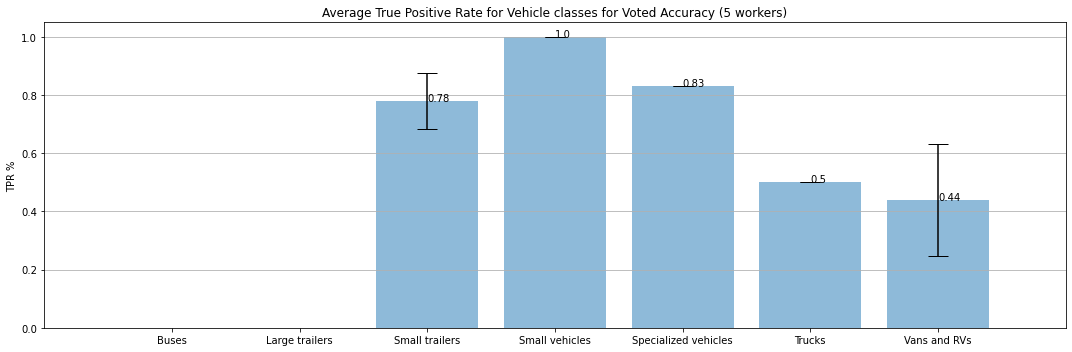

In [45]:
roundedmean = np.round(mean['tpr'],2)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(range(len(classes)), roundedmean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('TPR %')
ax.set_ylim(0,1.05)
ax.set_xlim(-1,len(classes))
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_title('Average True Positive Rate for Vehicle classes for Voted Accuracy (5 workers)')
ax.yaxis.grid(True)
for i in range(len(classes)):
    ax.annotate(roundedmean[i], (i, roundedmean[i]))
# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(output_results,'bar_plot_with_error_bars_5workers.png'))
plt.show()

### Save the confusion matrix for 5 workers voted accuracy to CSV file

In [46]:
save_file(groupwise_cm_5,os.path.join(output_results,"groupwise_cm_5.csv"))

In [47]:
groupwise_cm_5[["group","class","tp","fp","fn","tn"]][groupwise_cm_5['class'] == 'Trucks']

,group,class,tp,fp,fn,tn
0,1,Trucks,0.5,0.0,0.5,1.0
7,1,Trucks,0.5,0.0,0.5,1.0
14,1,Trucks,0.5,0.0,0.5,1.0


In [49]:
df = groupwise_cm.iloc[::70, :]
df

,hitid,group,class,tp,fp,fn,tn
0,3AQN9REUUMYRV96KY0O8M5OI1BPDY4,1,Trucks,0.5,0.000000,0.5,1.000000
70,3GKAWYFRBWBXMVEJ7DSP9EV6XZJPD5,1,Trucks,1.0,0.043478,0.0,0.956522
140,3LEG2HW4VM5YS8R9WLC311QYY282F7,1,Trucks,0.5,0.086957,0.5,0.913043


In [50]:
save_file(df,os.path.join(output_results,"groupwise_accuracies.csv"))

In [51]:
all_answers.groupby(['WorkerId','HITId','image_url']).size().reset_index().rename(columns={0:'count'})

,WorkerId,HITId,image_url,count
0,A16BGGCNJF87IX,3LEG2HW4VM5YS8R9WLC311QYY282F7,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0001/0001_0001_2462-6635.png,1
1,A16BGGCNJF87IX,3LEG2HW4VM5YS8R9WLC311QYY282F7,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0001/0001_0001_7835-19327.png,1
2,A16BGGCNJF87IX,3LEG2HW4VM5YS8R9WLC311QYY282F7,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0002/0001_0002_13119-7517.png,1
3,A16BGGCNJF87IX,3LEG2HW4VM5YS8R9WLC311QYY282F7,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0002/0001_0002_6167-2158.png,1
4,A16BGGCNJF87IX,3LEG2HW4VM5YS8R9WLC311QYY282F7,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0002/0001_0002_8768-7900.png,1
...,...,...,...,...
370,AJRY9ALX8069Y,3AQN9REUUMYRV96KY0O8M5OI1BPDY4,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0004/0001_0004_6124-8562.png,1
371,AJRY9ALX8069Y,3AQN9REUUMYRV96KY0O8M5OI1BPDY4,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0004/0001_0004_687-10289.png,1
372,AJRY9ALX8069Y,3AQN9REUUMYRV96KY0O8M5OI1BPDY4,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0004/0001_0004_7734-3872.png,1
373,AJRY9ALX8069Y,3AQN9REUUMYRV96KY0O8M5OI1BPDY4,https://mturk-s3-cg.s3.amazonaws.com/task1/batch100/0001_0005/0001_0005_12039-543.png,1


In [52]:
len(all_answers.groupby(['WorkerId','HITId','image_url']))

376